All files verified!
Epoch 1/20, Loss: 0.0000
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Test Accuracy of the LSTM model: 100.00%
Best outcome for Defender: 1


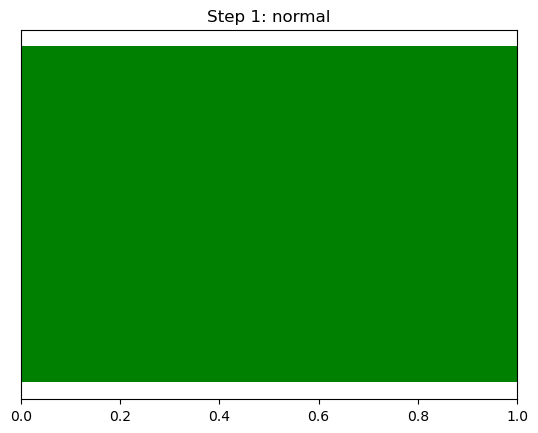

In [ ]:
# ==============================
# Imports
# ==============================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os

# ==============================
# 1. Define File Paths
# ==============================
train_files = [
   "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training/Pre_train_D_0.csv",
   "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training/Pre_train_D_1.csv",
   "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training/Pre_train_D_2.csv",
   "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training/Pre_train_S_0.csv",
   "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training/Pre_train_S_1.csv",
    "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training/Pre_train_S_2.csv"
]

test_files = [
    "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/1_Submission/Pre_submit_D.csv",
    "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/1_Submission/Pre_submit_S.csv"
]

# ==============================
# 2. Verify Files Exist
# ==============================
all_files = train_files + test_files
for f in all_files:
    if not os.path.exists(f):
        raise FileNotFoundError(f"File not found: {f}")
print("All files verified!")

# ==============================
# 3. Load CSVs
# ==============================
def load_csv(files):
    dfs = [pd.read_csv(f) for f in files]
    return pd.concat(dfs, ignore_index=True)

train_df = load_csv(train_files)
test_df = load_csv(test_files)

# ==============================
# 4. Convert Hex Columns to Numeric
# ==============================
def preprocess_can(df):
    df = df.copy()
    for col in df.columns:
        df[col] = df[col].apply(lambda x: int(str(x), 16) if isinstance(x, str) and all(c in "0123456789ABCDEFabcdef" for c in str(x)) else x)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(0)
    return df

train_df = preprocess_can(train_df)
test_df = preprocess_can(test_df)

# ==============================
# 5. Split Features and Labels
# ==============================
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM (samples, seq_len, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# ==============================
# 6. PyTorch Dataset
# ==============================
class CAN_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CAN_Dataset(X_train_lstm, y_train)
test_dataset = CAN_Dataset(X_test_lstm, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==============================
# 7. LSTM Model
# ==============================
class LSTM_DEFENDER(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM_DEFENDER, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size)
        c0 = torch.zeros(1, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train_lstm.shape[2]
hidden_size = 64
num_classes = len(np.unique(y_train))
model = LSTM_DEFENDER(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ==============================
# 8. Train LSTM
# ==============================
epochs = 20
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ==============================
# 9. Evaluate Model Accuracy
# ==============================
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy of the LSTM model: {accuracy:.2f}%")

# ==============================
# 10. Game-Theoretic Simulation
# ==============================
class GameState:
    def __init__(self, network_status, depth=0, test_idx=0):
        self.network_status = network_status
        self.depth = depth
        self.test_idx = test_idx
    def is_terminal(self):
        return self.depth >= 3 or self.network_status == "compromised"
    def evaluate(self):
        return 1 if self.network_status == "normal" else -1 if self.network_status == "compromised" else 0
    def get_children(self, player):
        children = []
        if player == "attacker":
            for i in range(self.test_idx, min(self.test_idx + 3, X_test_lstm.shape[0])):
                children.append(GameState("under_attack", self.depth + 1, i))
        else:
            for i in range(self.test_idx, min(self.test_idx + 3, X_test_lstm.shape[0])):
                packet = torch.tensor(X_test_lstm[i:i + 1], dtype=torch.float32)
                with torch.no_grad():
                    pred = model(packet)
                    pred_label = torch.argmax(pred, dim=1).item()
                status = "normal" if pred_label == 0 else "under_attack"
                children.append(GameState(status, self.depth + 1, i + 1))
        return children

def alpha_beta(node, depth, alpha, beta, maximizing_player, log_list):
    if depth == 0 or node.is_terminal():
        log_list.append((node.depth, node.network_status, "Terminal"))
        return node.evaluate()
    
    if maximizing_player:
        max_eval = float('-inf')
        for child in node.get_children("defender"):
            log_list.append((child.depth, child.network_status, "Defender"))
            eval = alpha_beta(child, depth - 1, alpha, beta, False, log_list)
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = float('inf')
        for child in node.get_children("attacker"):
            log_list.append((child.depth, child.network_status, "Attacker"))
            eval = alpha_beta(child, depth - 1, alpha, beta, True, log_list)
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

# ==============================
# 11. Run Simulation & Log
# ==============================
log_list = []
initial_state = GameState("normal", 0, 0)
best_score = alpha_beta(initial_state, 3, float('-inf'), float('inf'), True, log_list)
print("Best outcome for Defender:", best_score)

# ==============================
# 12. Dynamic Visualization
# ==============================
fig, ax = plt.subplots()
statuses = [status for _, status, _ in log_list]

def update(frame):
    ax.clear()
    color = "green" if statuses[frame] == "normal" else "red"
    ax.barh([0], [1], color=color)
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_title(f"Step {frame+1}: {statuses[frame]}")

ani = animation.FuncAnimation(fig, update, frames=len(statuses), interval=500)
HTML(ani.to_jshtml())